In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio.v2 as imageio
from skimage import io,  feature, color
from skimage.color import rgb2gray, lab2rgb
from scipy.ndimage import convolve, gaussian_filter
from skimage.util import random_noise

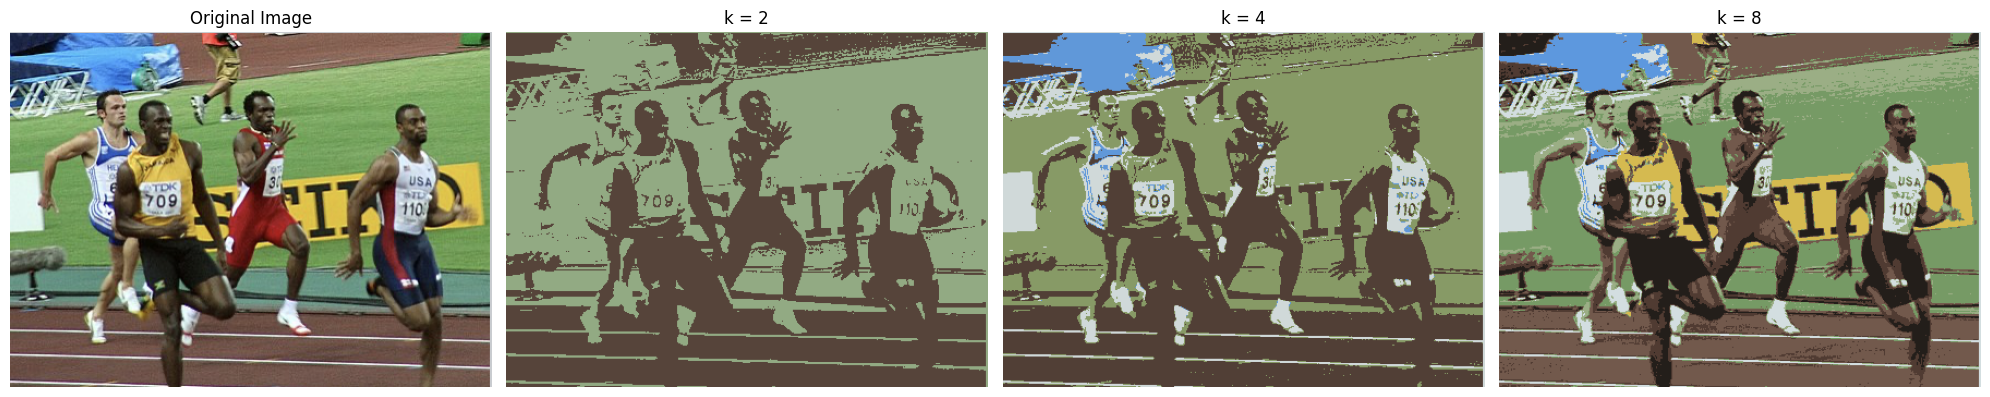

In [2]:
### 1. Image Segmentation: K-Means Clustering Method

def k_means_plus_plus(pixels, k):
    n_pixels = len(pixels)
    centers = [pixels[np.random.randint(n_pixels)]]
    distances = np.full(n_pixels, np.inf)

    for _ in range(1, k):
        distances = np.minimum(distances, np.linalg.norm(pixels - centers[-1], axis=1)**2)
        total_distance = np.sum(distances)
        probabilities = distances / total_distance
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        new_center_idx = np.searchsorted(cumulative_probabilities, r)
        centers.append(pixels[new_center_idx])

    return np.array(centers)

def k_means(pixels, k, max_iters=100):
    centers = k_means_plus_plus(pixels, k)
    for _ in range(max_iters):
        distances = np.linalg.norm(pixels[:, np.newaxis] - centers, axis=2)
        clusters = np.argmin(distances, axis=1)
        new_centers = np.array([pixels[clusters == j].mean(axis=0) for j in range(k)])
        if np.allclose(centers, new_centers, atol=1e-4):
            break
        centers = new_centers

    return centers, clusters


# Image loading and preprocessing
image = io.imread('Usain_Bolt.png')[:, :, :3]  
pixels = image.reshape(-1, 3)

# Plot setup
fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
axs = axs.ravel()

# Show original image in the first subplot
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Define the values of k
k_values = [2, 4, 8]

# Generate clustered images for k = 2, 4, 8
for index, k in enumerate(k_values, start=1):
    centers, clusters = k_means(pixels.astype(float), k)  
    new_pixels = centers[clusters]
    clustered_image = new_pixels.reshape(image.shape)

    axs[index].imshow(clustered_image.astype(np.uint8))
    axs[index].set_title(f'k = {k}')
    axs[index].axis('off')

# Layout adjustment and show plot
plt.tight_layout()
plt.show()

* Image Source: [Wikipedia](https://en.wikipedia.org/wiki/Usain_Bolt)
<br>

* **k mean clustering method** : K-means clustering is an algorithm used to partition a set of observations into K clusters, minimizing the within-cluster sum of squares. The objective function is defined as:
    * $\sigma_{\omega}^2 =\sum_{j=1}^K\sum_{i \in S_j} (x_i-\mu_j)^2$ <br>
where $x_i$ are the data points, $\mu_j$ are the cluster centers, and $S_j$ are the clusters.<br><br>
* **Algorithm steps**:
    1. Initialization: Convert an image into a matrix of pixels, where each pixel is a vector in a color space.
    2. Center Selection: Randomly select K initial cluster centers from the pixel vectors.
    3. Assignment: Assign each pixel to the nearest cluster center based on Euclidean distance.
    4. Update: Recalculate the cluster centers as the mean of the vectors in each cluster.
    5. Convergence Check: Repeat the assignment and update steps until the cluster assignments no longer change.<br><br>
    
* While generally applicable to data clustering, in image processing, k-means is utilized for color quantization and segmentation, aiding in tasks like object detection and medical imaging, where identifying distinct color groups is crucial.

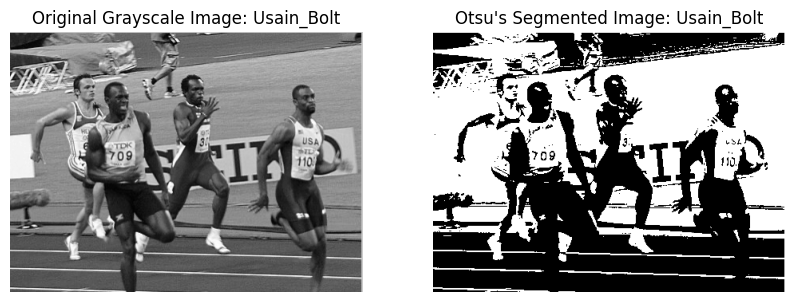

In [3]:
### 2. Image Segmentation: Otsu's Method

def otsu_thresholding_from_scratch(image_path):
    # Read and convert the image to grayscale
    image = io.imread(image_path)[:, :, :3]
    
    # Convert to grayscale
    gray_image = rgb2gray(image)
    gray_image = (gray_image * 255).astype(np.uint8) 
    
    # Calculate histogram
    histogram = np.bincount(gray_image.ravel(), minlength=256)
    
    # Total number of pixels
    total = gray_image.size
    
    # Compute total mean
    mean_total = np.dot(histogram, np.arange(256)) / total
    
    # Initialize variables
    weight_background = 0
    sum_background = 0
    max_variance = 0
    optimal_threshold = 0
    
    for t in range(256):
        weight_background += histogram[t]
        if weight_background == 0:
            continue
        
        weight_foreground = total - weight_background
        if weight_foreground == 0:
            break
        
        sum_background += t * histogram[t]
        
        mean_background = sum_background / weight_background
        mean_foreground = (mean_total * total - sum_background) / weight_foreground
        
        # Calculate between class variance
        variance_between = weight_background * weight_foreground * ((mean_background - mean_foreground) ** 2)
        
        # Update optimal threshold
        if variance_between > max_variance:
            max_variance = variance_between
            optimal_threshold = t
    
    # Create binary image
    segmented_image = (gray_image > optimal_threshold).astype(np.uint8) * 255
    
    # Extract the title from the image path
    title = image_path.split('/')[-1].split('.')[0] 
    
    # Display the images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(gray_image, cmap='gray')
    ax[0].set_title(f'Original Grayscale Image: {title}')
    ax[0].axis('off')
    
    ax[1].imshow(segmented_image, cmap='gray')
    ax[1].set_title(f"Otsu's Segmented Image: {title}")
    ax[1].axis('off')
    
    plt.show()
    
    return segmented_image, optimal_threshold


segmented_image,optimal_threshold = otsu_thresholding_from_scratch('Usain_Bolt.png')


* **Otsu's method** is a thresholding technique used to automatically separate an image into foreground and background using histogram analysis. It aims to determine a threshold t that maximizes the between-class variance, $\sigma_b^2(t)$, effectively enhancing class separability. <br><br>

* **Mathematical Formulation**:
* The algorithm calculates the threshold t by maximizing the inter-class variance: 
    * $\sigma_b^2(t)=\omega_1(t)\omega_2(t)(\mu_1(t)-\mu_2(t))^2$ <br>
    where:
    * $\omega_1(t)$ and $\omega_2(t)$  are the probabilities of the two classes separated by threshold t.
    * $\mu_1(t)$ and $\mu_2(t)$ are the means of these classes.
    * $\sigma_b^2(t)$ is the between-class variance, computed as $\sigma^2 -\sigma_{\omega}^2(t)$ <br><br>
   
* **Algorithm steps**:
    1. Conversion and Normalization: Convert the image to grayscale and normalize to a range of 0-255.
    2. Histogram Calculation: Compute the histogram of the grayscale image.
    3. Threshold Calculation: 
        * For each potential threshold t, calculate the probabilties $\omega_1(t)$ and $\omega_2(t)$, and the means $\mu_1(t)$ and $\mu_2(t)$.
        * Compute $\sigma_b^2(t)$ for each t and select the t that maximizes this variance.
     4. Segmenation: Use the optimal threshold to convert the grayscale image into a binary image.<br><br>
     
* **Applications**:
* Otsu's method is widely used in various image processing applications such as document analysis for OCR, medical imaging for segmenting scans, object detection in visual surveillance, enhancement in biometric systems, agricultural imaging for plant disease identification, and quality control in manufacturing.

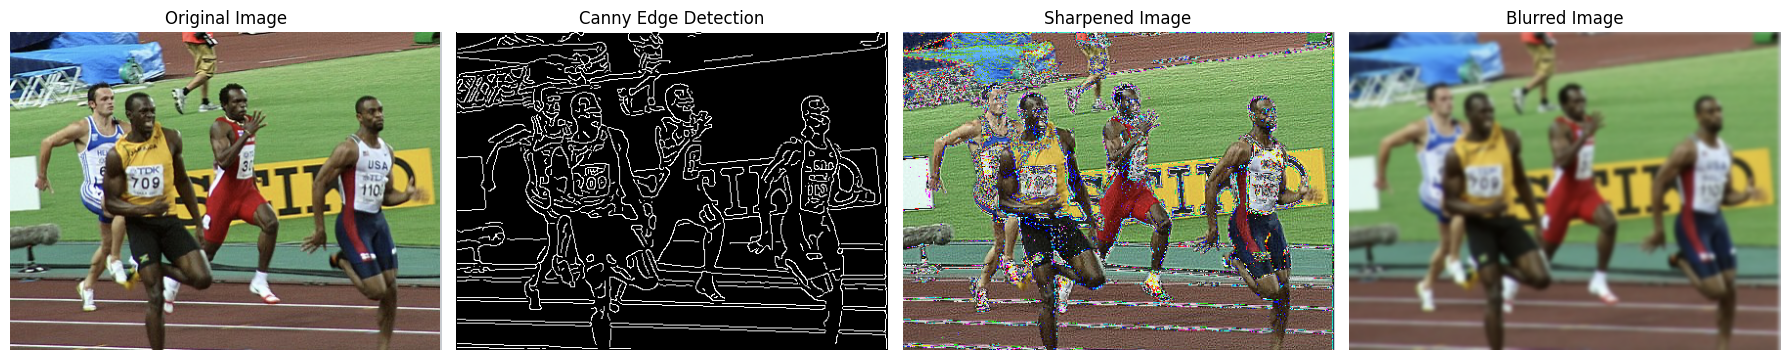

In [4]:
### 3. Image Filtering using Convolution

def apply_image_processing(image_path):
    # Load the image
    image = imageio.imread(image_path)[:, :, :3] 

    # Convert to grayscale for edge detection
    image_gray = color.rgb2gray(image)
    image_gray = (image_gray * 255).astype(np.uint8)

    # Canny edge detection
    canny_edges = feature.canny(image_gray, sigma=1.5)

    # Kernels
    sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    blur_sigma = 2  # Sigma for Gaussian blur

    # Apply sharpening to each color channel
    sharpened_image = np.zeros_like(image)
    for i in range(3):  # There are 3 channels: R, G, B
        sharpened_image[:, :, i] = convolve(image[:, :, i], sharpening_kernel)

    # Apply Gaussian blur to each color channel
    blurred_image = np.zeros_like(image)
    for i in range(3):
        blurred_image[:, :, i] = gaussian_filter(image[:, :, i], sigma=blur_sigma)

    # Display images
    plt.figure(figsize=(18, 6))
    titles = ['Original Image', 'Canny Edge Detection', 'Sharpened Image', 'Blurred Image']
    images = [image, canny_edges, sharpened_image, blurred_image]

    for i, (img, title) in enumerate(zip(images, titles), start=1):
        plt.subplot(1, 4, i)
        if title == 'Canny Edge Detection':  
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


apply_image_processing('Usain_Bolt.png')


* **Image filtering** is a technique used in image processing to enhance images, extract information, or reduce noise. Filters can perform various tasks, such as sharpening, blurring, edge detection, and more. The main principle behind image filtering is to apply a kernel (also called a convolution matrix or mask) to each pixel of the image. This operation modifies the value of each pixel by combining it with values from surrounding pixels. The specific effect—whether sharpening, blurring, or detecting edges—depends on the values in the kernel.<br><br>
* **Convolution** is the mathematical operation used to apply the kernel to the image. The following is a simplified overview of how it works in image filtering:
    1. **Kernel**: A small matrix used to apply effects such as blurring, sharpening, and edge enhancement. Different kernels are used depending on the desired effect.
    2. **Sliding Window**: The kernel is "slid" over the image, and at each position, it covers a certain area of the image pixels.
    3. **Dot Product**: For each position of the kernel, a dot product is calculated between the kernel and the part of the image it covers. This means each value in the kernel is multiplied by the corresponding image pixel it covers, and the results are summed up to produce a single pixel in the output image.
    4. **Output Image**: The result of applying the kernel across all positions in the image produces the filtered image.<br><br>
    
* **Applications** of Image Filtering:
    * Sharpening: Enhances the edges in an image, making it look clearer.
    * Blurring: Used for smoothing the image, reducing detail and noise. It can also be used for privacy reasons, to defocus parts of an image, or to create a visual effect.
    * Edge Detection: Identifies significant changes in color in an image, which correspond to edges. This is useful in various applications, including computer vision, image segmentation, and object recognition.

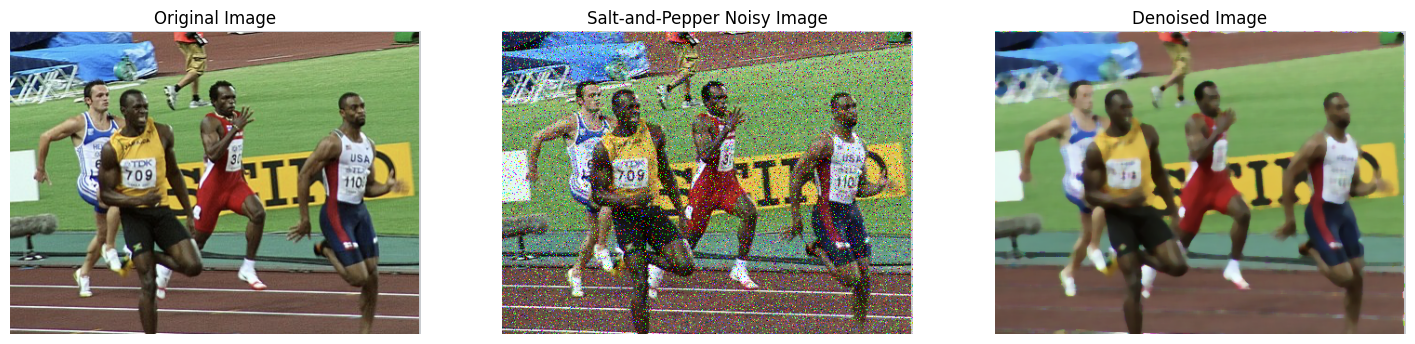

In [5]:
### 4. Add noise and denoise image

def add_salt_and_pepper_noise_to_rgb(img, amount=0.1, salt_vs_pepper=0.5):
    # Add salt-and-pepper noise 
    noisy_img = random_noise(img, mode='s&p', amount=amount, salt_vs_pepper=salt_vs_pepper)
    noisy_img = np.array(255 * noisy_img, dtype=np.uint8) 
    return noisy_img

def apply_median_blur_to_rgb(img, kernel_size=7):
    # Apply median blur to denoise
    denoised_img = cv2.medianBlur(img, kernel_size)
    return denoised_img

img = imageio.imread('Usain_Bolt.png')[:, :, :3] 
# Create salt-and-pepper noisy image 
sp_noisy_img = add_salt_and_pepper_noise_to_rgb(img, amount=0.1, salt_vs_pepper=0.5)

# Denoise the image using median blur
denoised_img = apply_median_blur_to_rgb(sp_noisy_img, kernel_size=7)

# Plotting the images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['Original Image', 'Salt-and-Pepper Noisy Image', 'Denoised Image']
images = [img, sp_noisy_img, denoised_img]

for ax, im, title in zip(axes, images, titles):
    ax.imshow(im)
    ax.set_title(title)
    ax.axis('off')

plt.show()


* Various image processing techniques in this notebook are utilized to transform and enhance visual data for clearer analysis and better decision-making. Using K-Means Clustering, images can be segmented into meaningful clusters for object detection. Otsu's Method allows for precise thresholding, ideal for background separation. Convolution filters help in emphasizing or reducing specific image features like edges or noise. Additionally, noise can be skillfully added and removed from images, ensuring they are optimized for high-stakes environments like medical diagnostics or quality control in manufacturing.